<a href="https://colab.research.google.com/github/krauseannelize/project-report-traveltide-rewards/blob/main/notebooks/traveltide_02_users_aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation Analysis | TravelTide Rewards Program

# Part 2: User-Level Aggregation

## 1 - Project Objective

The aim of this project is to support the Head of Marketing at TravelTide in designing a personalized rewards program that increases customer engagement and retention. Using a database of customer profiles, session activity, flight bookings, and hotel reservations, I analyze travel behavior, booking patterns, and discount sensitivity. My role as a Data Analyst is to deliver actionable insights that guide the personalization of perks, ensuring they align with distinct customer preferences.

`Part 2: User‑Level Aggregation` consolidates session data into aggregated customer profiles, enabling the exploration of spending habits, discount responsiveness, and behavioral signals at the individual level. This step builds on the session‑level foundation to uncover broader patterns across users, setting the stage for segmentation in Part 3.

## 2 - Data Import & Initial Inspection

### 2.1 Import Packages & Libraries

In [20]:
# Data manipulation
import pandas as pd
import numpy as np
import math

# Google Colab integration
from google.colab import drive

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [Part 1: Session‑Level Exploration](https://colab.research.google.com/drive/1rMwRBKmkhHxbGOm-ZipeaudbIYUoIlTs?usp=sharing), the raw sessions dataset was thoroughly cleaned and enriched with additional features. The resulting dataset was exported as `traveltide-sessions-enriched.csv`, providing a reliable foundation for further analysis. In this notebook, I simply reload that enriched dataset and shift the focus from individual sessions to aggregated user profiles.

### 2.2 Load Dataset

In [21]:
# Mount Google Drive
drive.mount('/content/drive')

# Read vehicle dataset as pandas DataFrame
enriched_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ms-data/traveltide-sessions-enriched.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.3 Inspect Dataset

In [22]:
# Confirm vehicle dataset has loaded successfully
enriched_df.head()

,session_id,user_id,trip_id,page_clicks,gender,married,has_children,home_country,home_city,home_airport,...,booking_type,booking_status,trip_duration_days,trip_category,trip_distance_km,trip_discount,trip_discount_amount,base_trip_cost,total_trip_cost,hotel_brand
0,23557-3f6bd6be250e45959b33b808ac525df6,23557,NaN,32,f,True,False,usa,new york,lga,...,browsing,none,0,NaN,NaN,False,0.0,0.0,0.0,NaN
1,120851-bfeb515377f44fdbbb9d9642dc0c7178,120851,NaN,5,f,True,True,usa,santa ana,sna,...,browsing,none,0,NaN,NaN,False,0.0,0.0,0.0,NaN
2,229108-d2b0f9bc7aea425189cb943fa1706810,229108,NaN,12,f,False,False,usa,burlington,btv,...,browsing,none,0,NaN,NaN,True,0.2,0.0,0.0,NaN
3,264470-71e8f4d269aa44308aa34ffd1c2d0c18,264470,NaN,8,f,False,True,usa,bakersfield,bfl,...,browsing,none,0,NaN,NaN,False,0.0,0.0,0.0,NaN
4,348863-e3c9ba813fc84210a236a3a11e364859,348863,NaN,10,f,True,False,usa,san antonio,skf,...,browsing,none,0,NaN,NaN,False,0.0,0.0,0.0,NaN


In [23]:
# Inspect shape of sessions dataset
print(f"---DATASET SHAPE---\nRows: {enriched_df.shape[0]}\nColumns: {enriched_df.shape[1]}")

---DATASET SHAPE---
Rows: 48682
Columns: 32


In [24]:
# Review basic information about enriched dataset
enriched_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48682 entries, 0 to 48681
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   session_id            48682 non-null  object 
 1   user_id               48682 non-null  int64  
 2   trip_id               16233 non-null  object 
 3   page_clicks           48682 non-null  int64  
 4   gender                48682 non-null  object 
 5   married               48682 non-null  bool   
 6   has_children          48682 non-null  bool   
 7   home_country          48682 non-null  object 
 8   home_city             48682 non-null  object 
 9   home_airport          48682 non-null  object 
 10  origin_airport        13805 non-null  object 
 11  destination           13805 non-null  object 
 12  destination_airport   13805 non-null  object 
 13  seats                 48682 non-null  int64  
 14  checked_bags          48682 non-null  int64  
 15  trip_airline       

## 3 - Data Preprocessing

The dataset was properly cleaned in Part 1 and exported to CSV. I confirmed that all variables imported with the expected datatypes, that no rows or features were dropped, and the dataset is now ready for aggregation. However, it contains categorical features such as booking type, booking status, and trip category, which hold valuable information I want to preserve at the individual level. To ensure I can calculate meaningful ratios and segment behaviors without losing detail, I will transform these categorical variables using one‑hot encoding, ensuring that counts of each category are retained within user profiles.

In [25]:
# Define categorical columns and their shorter prefixes
categorical_cols = {
    "booking_type": "type"
    , "booking_status": "status"
    , "trip_category": "category"
}

# One-hot encode with custom prefixes
encoded_df = pd.get_dummies(
    enriched_df
    , columns=categorical_cols.keys()
    , prefix=categorical_cols.values()
)

# Confirm new dummy columns
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48682 entries, 0 to 48681
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   session_id             48682 non-null  object 
 1   user_id                48682 non-null  int64  
 2   trip_id                16233 non-null  object 
 3   page_clicks            48682 non-null  int64  
 4   gender                 48682 non-null  object 
 5   married                48682 non-null  bool   
 6   has_children           48682 non-null  bool   
 7   home_country           48682 non-null  object 
 8   home_city              48682 non-null  object 
 9   home_airport           48682 non-null  object 
 10  origin_airport         13805 non-null  object 
 11  destination            13805 non-null  object 
 12  destination_airport    13805 non-null  object 
 13  seats                  48682 non-null  int64  
 14  checked_bags           48682 non-null  int64  
 15  tr

## 4 - User Aggregation

### 4.1 Data Extraction

In [26]:
# Define one-hot columns (booking type, status, category flags)
one_hot_cols = [col for col in encoded_df.columns if col.startswith(("type_", "status_", "category_"))]

user_agg = encoded_df.groupby("user_id").agg(
    # Demographics
    gender=("gender", "first")
    , married=("married", "first")
    , has_children=("has_children", "first")
    , home_country=("home_country", "first")
    , home_city=("home_city", "first")
    , home_airport=("home_airport", "first")
    , user_age=("user_age", "max")
    , account_age=("account_age_months", "max")

    # Sessions
    , total_sessions=("session_id", "count")
    , avg_session_duration=("session_duration_min", "mean")
    , avg_page_clicks=("page_clicks", "mean")
    , avg_clicks_per_min=("clicks_per_min", "mean")

    # Flights
    , avg_seats=("seats", "mean")
    , avg_checked_bags=("checked_bags", "mean")
    , num_trip_discounts=("trip_discount_amount", lambda x: (x > 0).sum())
    , avg_trip_discount_amount=("trip_discount_amount", lambda x: x[x > 0].mean())
    , total_airlines=("trip_airline", "nunique")
    , top_airline=("trip_airline", lambda x: x.mode().iat[0] if not x.mode().empty else None)
    , total_origin_airports=("origin_airport", "nunique")
    , total_destinations=("destination", "nunique")
    , top_destination=("destination", lambda x: x.mode().iat[0] if not x.mode().empty else None)
    , total_destination_airports=("destination_airport", "nunique")

    # Hotels
    , avg_rooms=("rooms", "mean")
    , total_hotels=("hotel_name", "nunique")
    , total_hotel_brands=("hotel_brand", "nunique")
    , top_hotel_brand=("hotel_brand", lambda x: x.mode().iat[0] if not x.mode().empty else None)

    # Trips
    , total_trips=("trip_id", "count")
    , avg_trip_duration_days=("trip_duration_days", "mean")
    , avg_trip_distance_km=("trip_distance_km", "mean")
    , avg_base_trip_cost=("base_trip_cost", "mean")
    , avg_total_trip_cost=("total_trip_cost", "mean")
).reset_index()

# Add one-hot sums (counts of booking types, statuses, categories per user)
user_agg[one_hot_cols] = encoded_df.groupby("user_id")[one_hot_cols].sum().reset_index(drop=True)

# Browsing frequency: sessions per month
user_agg["browsing_frequency"] = (user_agg["total_sessions"] / user_agg["account_age"]).round(2)

# Booking frequency: bookings per month
user_agg["booking_frequency"] = ((user_agg["status_complete"] + user_agg["status_cancelled"]) / user_agg["account_age"]).round(2)

# Booking conversion: proportion of sessions that end in a completed booking
user_agg["booking_conversion"] = ((user_agg["status_complete"] + user_agg["status_cancelled"]) / user_agg["total_sessions"]).round(2)

# Cancellation rate: proportion of bookings that were cancelled
user_agg["cancellation_rate"] = (user_agg["status_cancelled"] / (user_agg["status_complete"] + user_agg["status_cancelled"])).round(2)

In [27]:
# Extract all float columns
float_cols = user_agg.select_dtypes(include="float").columns

# Loop through each float column and round to 2 decimals
for col in float_cols:
    user_agg[col] = user_agg[col].round(2)

### 4.2 Data Inspection

In [28]:
# Inspect shape of sessions dataset
print(f"---DATASET SHAPE---\nRows: {user_agg.shape[0]}\nColumns: {user_agg.shape[1]}")

---DATASET SHAPE---
Rows: 5987
Columns: 49


In [29]:
# Preview user aggregated dataset
user_agg.head()

,user_id,gender,married,has_children,home_country,home_city,home_airport,user_age,account_age,total_sessions,...,status_complete,status_none,category_extended,category_other,category_week,category_weekend,browsing_frequency,booking_frequency,booking_conversion,cancellation_rate
0,23557,f,True,False,usa,new york,lga,66,41,8,...,2,6,1,1,0,0,0.20,0.05,0.25,0.0
1,94883,f,True,False,usa,kansas city,mci,52,34,8,...,2,6,0,1,1,0,0.24,0.06,0.25,0.0
2,101486,f,True,True,usa,tacoma,tcm,52,34,8,...,2,6,2,0,0,0,0.24,0.06,0.25,0.0
3,101961,f,True,False,usa,boston,bos,44,34,8,...,5,3,4,0,0,1,0.24,0.15,0.62,0.0
4,106907,f,True,True,usa,miami,tnt,46,34,8,...,1,6,2,0,0,0,0.24,0.06,0.25,0.5


In [30]:
# Review basic information about sessions dataset
user_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5987 entries, 0 to 5986
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     5987 non-null   int64  
 1   gender                      5987 non-null   object 
 2   married                     5987 non-null   bool   
 3   has_children                5987 non-null   bool   
 4   home_country                5987 non-null   object 
 5   home_city                   5987 non-null   object 
 6   home_airport                5987 non-null   object 
 7   user_age                    5987 non-null   int64  
 8   account_age                 5987 non-null   int64  
 9   total_sessions              5987 non-null   int64  
 10  avg_session_duration        5987 non-null   float64
 11  avg_page_clicks             5987 non-null   float64
 12  avg_clicks_per_min          5987 non-null   float64
 13  avg_seats                   5987 

In [31]:
# Count no duplicate rows
print(f"Number of duplicate rows: {user_agg.duplicated().sum()}")

Number of duplicate rows: 0


In [32]:
# Count missing values per column
user_agg.isna().sum().sort_values(ascending=False)

,0
top_airline,850
top_destination,850
avg_trip_distance_km,850
top_hotel_brand,628
cancellation_rate,479
avg_trip_discount_amount,457
user_id,0
has_children,0
gender,0
account_age,0


### 4.3 Export User Aggregation

In [33]:
# Export user aggregation dataset to .csv to reuse
user_agg.to_csv('/content/drive/MyDrive/Colab Notebooks/ms-data/traveltide-user-aggregation.csv', index=False)

### 4.4 Data Visualization

#### 4.4.1 User Behavior by Age Group and Family Status

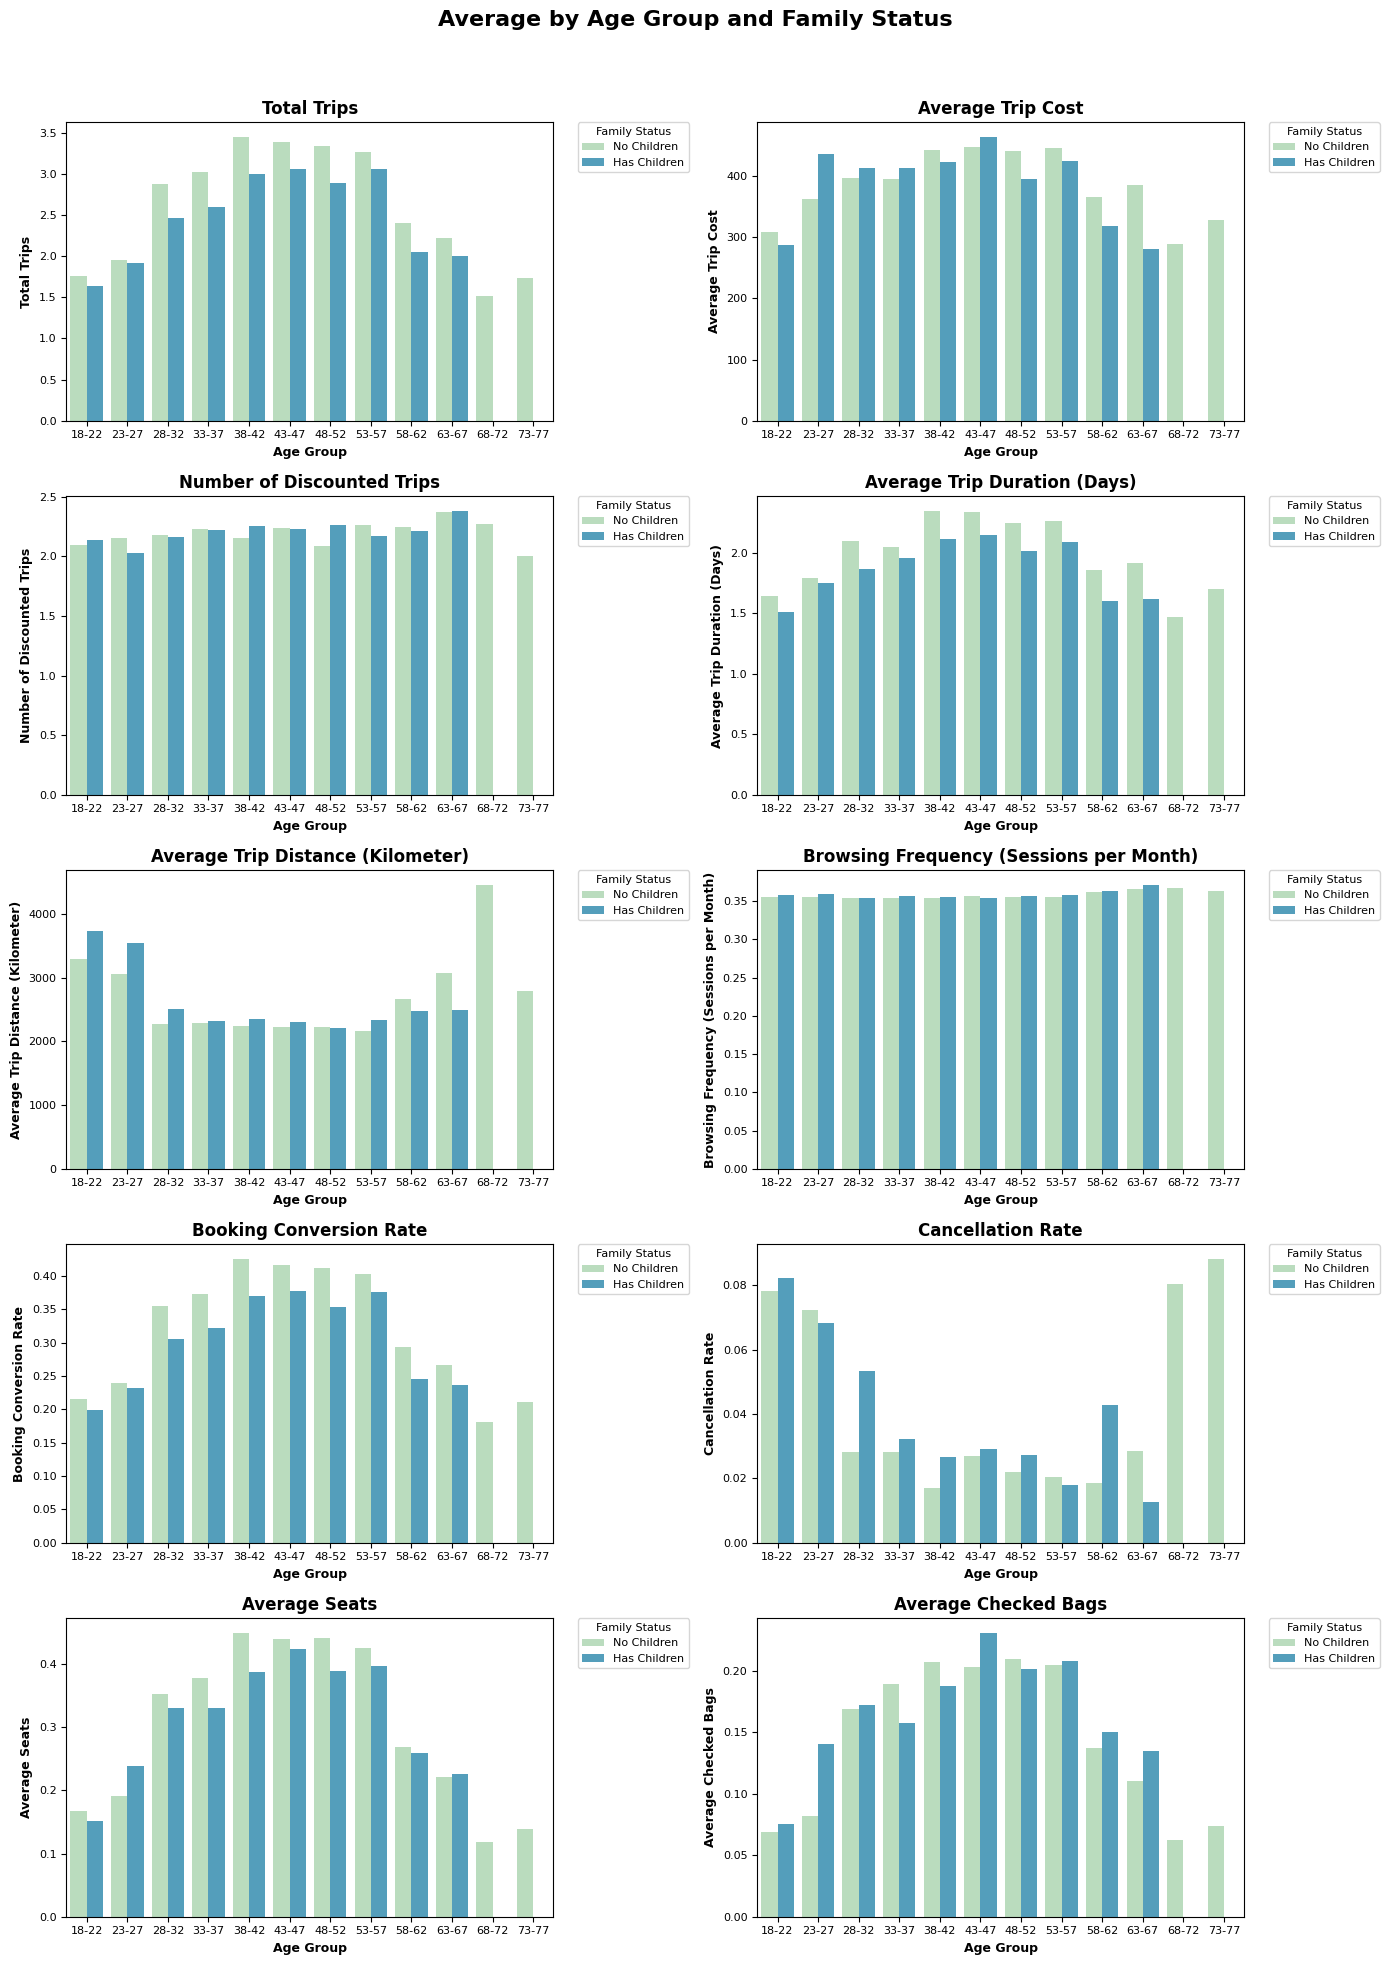

In [34]:
# Create filtered dataset to visualize age groups
age_groups = user_agg[user_agg["total_trips"] > 0].copy()

# Bin ages into groups for readability
age_bins = list(range(18, 81, 5))  # [18, 23, 28, ..., 78]
age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]
age_groups["age_group"] = pd.cut(
    age_groups["user_age"]
    , bins=age_bins
    , labels=age_labels
    , right=False
)

# Change boolean labels for readability
age_groups["has_children_label"] = age_groups["has_children"].map({True: "Has Children", False: "No Children"})

# Function to create a barplot of user age group distribution and family status
def plot_user_groups(df, col, label, ax):
    sns.barplot(
        data=df
        , x="age_group"
        , y=col
        , hue="has_children_label"
        , palette="GnBu"
        , estimator="mean"
        , errorbar=None
        , ax=ax
    )
    ax.set_title(label, fontsize=12, fontweight="bold")
    ax.set_xlabel("Age Group", fontsize=9, fontweight="bold")
    ax.set_ylabel(label, fontsize=9, fontweight="bold")
    ax.legend(title="Family Status", title_fontsize=8, fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    # Move legend outside the plot to avoid overlap
    ax.legend(
        title="Family Status"
        , title_fontsize=8
        , fontsize=8
        , bbox_to_anchor=(1.05, 1)
        , loc="upper left"
        , borderaxespad=0
    )

# Columns to iterate over with improved labels
cols_age_compare = {
    "total_trips": "Total Trips"
    , "avg_total_trip_cost": "Average Trip Cost"
    , "num_trip_discounts": "Number of Discounted Trips"
    , "avg_trip_duration_days": "Average Trip Duration (Days)"
    , "avg_trip_distance_km": "Average Trip Distance (Kilometer)"
    , "browsing_frequency": "Browsing Frequency (Sessions per Month)"
    , "booking_conversion": "Booking Conversion Rate"
    , "cancellation_rate": "Cancellation Rate"
    , "avg_seats": "Average Seats"
    , "avg_checked_bags": "Average Checked Bags"
}

# Set plot figure with subplots (4 rows × 2 cols = 8 plots)
fig, axes = plt.subplots(5, 2, figsize=(14, 20))
axes = axes.flatten()

# Create a barplot for each variable
for i, (col, label) in enumerate(cols_age_compare.items()):
    plot_user_groups(age_groups, col, label, axes[i])

# Display plot
plt.suptitle("Average by Age Group and Family Status", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Looking across the age‑group and family‑status segments, several clear patterns emerge:

- Younger travelers (18–27) take fewer trips, spend less per trip, and show lower booking conversion rates. They also have higher cancellation rates, reflecting more tentative engagement.
- Late 20s to 30s see a sharp rise in trip counts and conversion rates, while cancellation rates drop. This suggests more reliable booking behavior as users mature.
- By the late 30s and early 40s, users without children show the highest booking conversion rates and the lowest cancellation rates.
- Users with children tend to book slightly fewer trips than peers without children, but their average trip costs are often higher. Discount usage remains steady across both groups.
- Average seats and checked bags increase with age, indicating a gradual shift toward group or family travel styles.

Overall, travel evolves from low‑commitment, lower‑spend patterns in youth toward more frequent, higher‑value, and more reliable bookings in middle age, with family status subtly shaping spending and reliability.

#### 4.4.2 Average Trips by Age Group and Trip Category

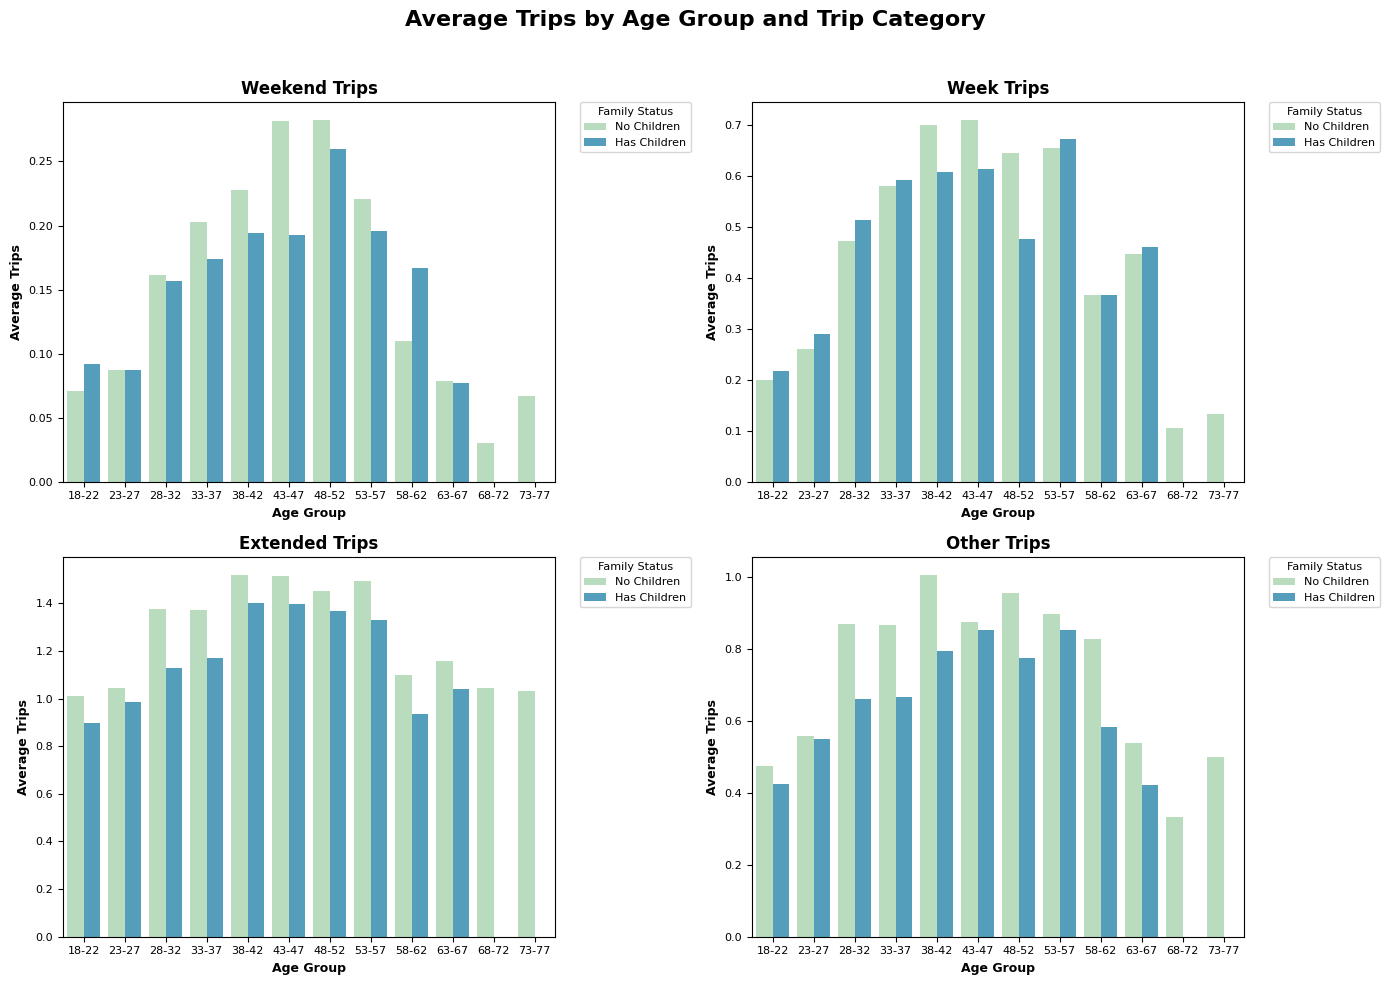

In [35]:
# Create filtered dataset to visualize age groups
age_groups = user_agg[user_agg["total_trips"] > 0].copy()

# Bin ages into groups for readability
age_bins = list(range(18, 81, 5))
age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]
age_groups["age_group"] = pd.cut(
    age_groups["user_age"]
    , bins=age_bins
    , labels=age_labels
    , right=False
)

# Change fsmily status labels for readability
age_groups["has_children_label"] = age_groups["has_children"].map({True: "Has Children", False: "No Children"})

# Melt trip category columns into long format
category_cols = ["category_weekend", "category_week", "category_extended", "category_other"]
age_groups_long = age_groups.melt(
    id_vars=["age_group", "has_children_label", "total_trips"],
    value_vars=category_cols,
    var_name="trip_category",
    value_name="trip_count"
)

# Map raw category codes to clean labels
category_map = {
    "category_weekend": "Weekend"
    , "category_week": "Week"
    , "category_extended": "Extended"
    , "category_other": "Other"
}

# Apply mapping
age_groups_long["trip_category_label"] = age_groups_long["trip_category"].map(category_map)

# Trip categories to compare (now using clean labels)
trip_categories = list(category_map.values())

# Function to create a barplot of user age group distribution for a trip category
def plot_trip_category(df, category, ax):
    sns.barplot(
        data=df[df["trip_category_label"] == category]
        , x="age_group"
        , y="trip_count"
        , palette="GnBu"
        , hue="has_children_label"
        , estimator="mean"
        , errorbar=None
        , ax=ax
    )
    ax.set_title(f"{category} Trips", fontsize=12, fontweight="bold")
    ax.set_xlabel("Age Group", fontsize=9, fontweight="bold")
    ax.set_ylabel("Average Trips", fontsize=9, fontweight="bold")
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    # Move legend outside the plot
    ax.legend(
        title="Family Status",
        title_fontsize=8,
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0
    )

# Set plot figure with subplots (2 rows × 2 cols = 4 plots)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Create a barplot for each trip category
for i, category in enumerate(category_map.values()):
    plot_trip_category(age_groups_long, category, axes[i])

# Display plot
plt.suptitle("Average Trips by Age Group and Trip Category", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Looking across age groups, trip categories, and family status, several important patterns emerge:

- Young travelers (18–22) show low trip counts overall, with little difference between those with or without children. Weekend trips are minimal, while extended and “other” trips are slightly more common.
- Early adulthood (23–27) brings more variation: travelers without children book more week‑long and weekend trips, while those with children lean toward “other” trips. Extended trips remain modest for both groups.
- Late 20s to 30s (28–37) mark a sharp rise in trip frequency. Travelers without children consistently book more trips across all categories, especially extended and “other” trips, while those with children remain active but at slightly lower levels.
- Peak travel years (38–47) show the highest averages overall. Extended and week trips dominate, with non‑parents booking more trips than parents in nearly every category. Weekend travel also rises significantly in this stage.
- Midlife (48–57) maintains high trip counts, though weekend trips diverge: parents average fewer weekend trips, while non‑parents sustain higher levels. Extended and “other” trips remain strong for both groups.
- Later years (58+) see a clear decline in trip frequency. Parents taper off more sharply, while non‑parents continue to book extended and “other” trips at modest levels. Weekend travel becomes rare across both groups.

Travel activity grows steadily from youth into middle age, peaking in the late 30s and 40s. Family status shapes the intensity of travel with non‑parents consistently booking more trips across categories, while parents show steadier but slightly lower engagement, especially in weekend travel.

#### 4.4.3 Top 10 Hotel Brands

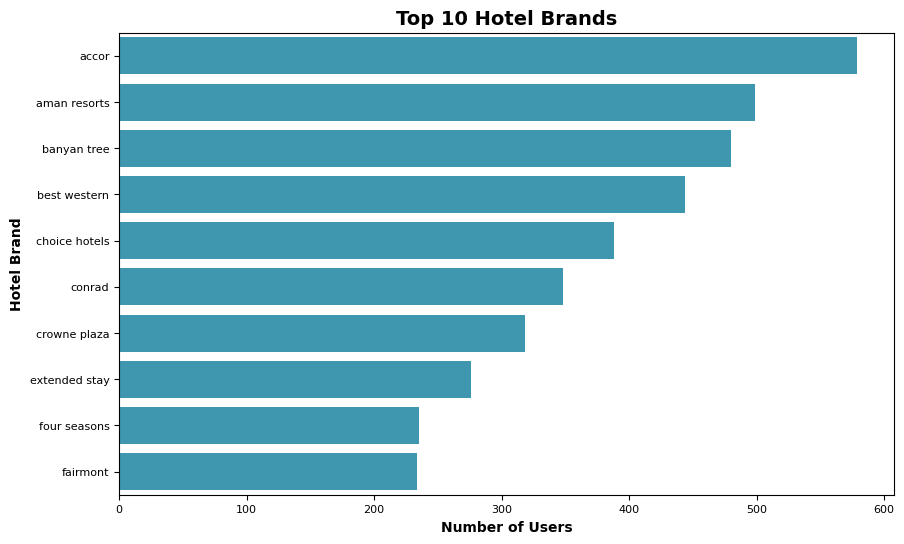

In [36]:
# Get the top 10 hotel brands by frequency, sorted descending
top10_order = (
    user_agg["top_hotel_brand"]
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Set up figure
plt.figure(figsize=(10,6))

# Create countplot
sns.countplot(
    data=user_agg,
    y="top_hotel_brand",
    order=top10_order,
    color="#2ca1c2"
)

# Add title and labels
plt.title("Top 10 Hotel Brands", fontsize=14, fontweight="bold")
plt.xlabel("Number of Users", fontsize=10, fontweight="bold")
plt.ylabel("Hotel Brand", fontsize=10, fontweight="bold")
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.show()

The Top 10 hotel brands visualization shows a clear mix of luxury and budget‑friendly chains, suggesting that customers span both premium and price‑sensitive segments. This distribution highlights the importance of segmenting by brand preference, as loyalty patterns differ between travelers seeking upscale experiences and those prioritizing affordability.

#### 4.4.4 Top 10 Airlines

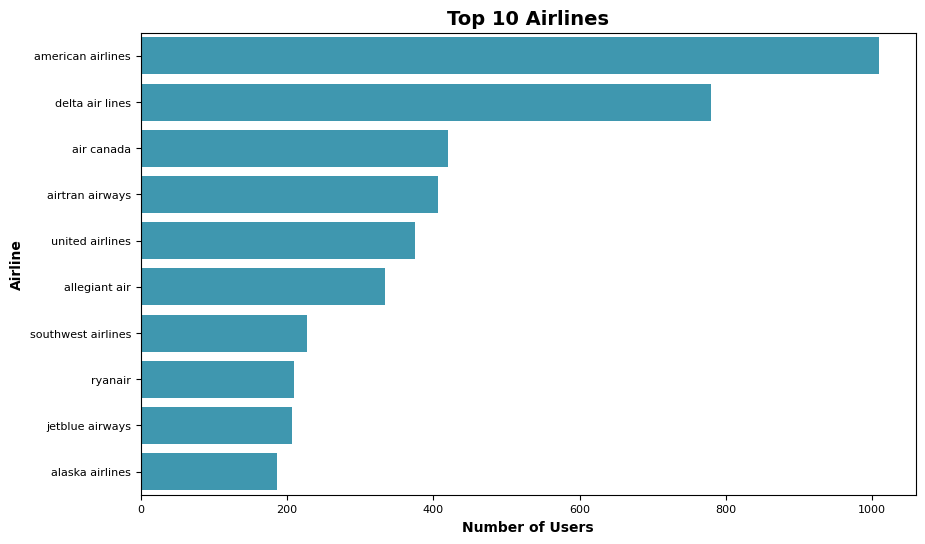

In [37]:
# Get the top 10 airlines by frequency, sorted descending
top10_order = (
    user_agg["top_airline"]
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Set up figure
plt.figure(figsize=(10,6))

# Create countplot
sns.countplot(
    data=user_agg,
    y="top_airline",
    order=top10_order,
    color="#2ca1c2"
)

# Add title and labels
plt.title("Top 10 Airlines", fontsize=14, fontweight="bold")
plt.xlabel("Number of Users", fontsize=10, fontweight="bold")
plt.ylabel("Airline", fontsize=10, fontweight="bold")
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.show()

The Top 10 airlines visualization highlights a mix of full‑service carriers and low‑cost operators, showing that customers span both convenience‑driven and budget‑sensitive segments. This distribution suggests segmentation opportunities based on travel style, with premium flyers favoring established global networks while value‑seekers lean toward affordable, point‑to‑point options.

#### 4.4.5 Top 10 Destinations

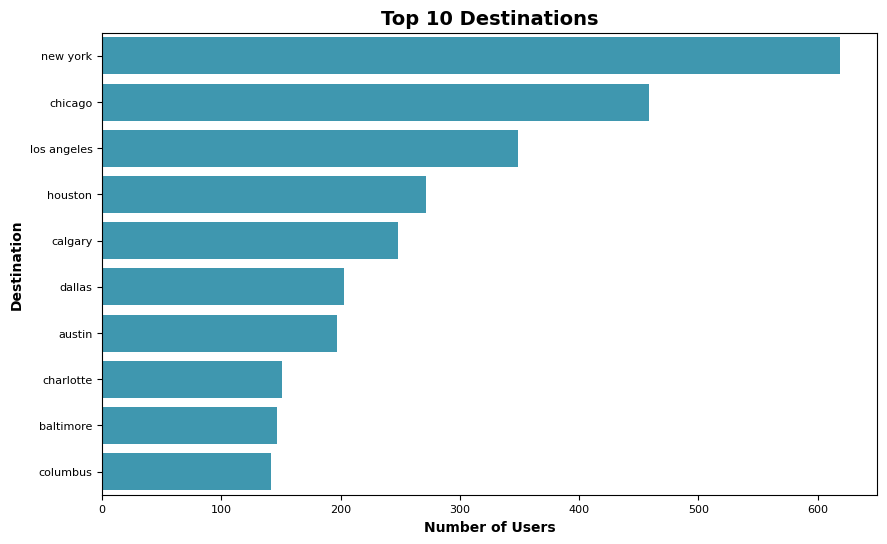

In [38]:
# Get the top 10 destinations by frequency, sorted descending
top10_order = (
    user_agg["top_destination"]
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Set up figure
plt.figure(figsize=(10,6))

# Create countplot
sns.countplot(
    data=user_agg,
    y="top_destination",
    order=top10_order,
    color="#2ca1c2"
)

# Add title and labels
plt.title("Top 10 Destinations", fontsize=14, fontweight="bold")
plt.xlabel("Number of Users", fontsize=10, fontweight="bold")
plt.ylabel("Destination", fontsize=10, fontweight="bold")
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.show()

The Top 10 destinations visualization shows a strong mix of major U.S. cities alongside a few Canadian hubs, reflecting both domestic and cross‑border travel demand. This distribution suggests segmentation opportunities between urban business travelers and leisure‑oriented customers, as some destinations serve primarily as corporate hubs while others attract cultural or lifestyle tourism.

## 5 - Summary and Next Steps

Key insights from the user‑level aggregation include:

- Younger travelers (18–27) take fewer trips, spend less per trip, and show higher cancellation rates, reflecting tentative engagement.
- Late 20s to 30s mark a turning point, with sharp rises in trip counts and conversion rates alongside declining cancellations, signaling more reliable booking behavior.
- By the late 30s and early 40s, non‑parents show the highest booking conversion rates and lowest cancellations, while parents spend more per trip but book slightly fewer journeys.
- Travel peaks in the late 30s and 40s, with extended and week‑long trips dominating, while weekend travel rises significantly in this stage.
- Midlife travelers (48–57) maintain strong activity, though weekend trips diverge with parents tapering off while non‑parents sustain higher levels. Later years (58+) see a decline in trip frequency, with non‑parents continuing modest extended travel.
- Across all ages, short getaways of one to three days remain the most common, underscoring that quick trips dominate overall travel behavior.

Together, these findings show how aggregated user profiles reveal demographic and behavioral patterns beyond session‑level data, with age and family status shaping both the intensity and reliability of travel.

Extending this analysis, [Part 3: Customer Segmentation](https://colab.research.google.com/drive/1FMX_TktLtzHXhSRsCGM-eXEz1qAtegNJ?usp=sharing) will combine these demographic signals to identify distinct traveler groups. This segmentation framework will enable actionable strategies for campaign design, tailoring perks and messaging to both premium and price‑sensitive segments, and maximizing engagement across life stages.